# Hierarchical pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import arviz as az
import corner

## Hierarchical setup first
I also want an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.


In [270]:
def model(planet_code, pendulum_code, times, pos_obs=None):
    # for every pendulum there are some shared parameters
    # in this case a_g
    #μ_G = numpyro.sample("μ_G", dist.Uniform(1.0,20.0))
    #σ_G = numpyro.sample("σ_G", dist.Uniform(0.0,1))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
    
    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own L, and theta values
        #a_g = numpyro.sample("a_g", dist.Gamma(μ_a_g, σ_a_g))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(0.02))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code])) * times)
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    
    
    #with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
    #    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Now non-hierarchical setup
I guess if this were truly non-hierarchical, you would just be sampling one pendulum?

Here, I'm just deleting the plates over the planets

In [257]:
def nonh_model(pendulum_code, times, pos_obs=None):
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own a_g, L, and theta values
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(0.2))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code])) * times)
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    
    #with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
    #    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate data
To do this make a dataframe and replicate a bunch of columns.

In [264]:
import pandas as pd
# Sample data for the DataFrame
data = {
    'length': [10, 15, 18, 12,
               9, 7, 11, 12],
    'theta': [jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4,
              jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4],
    'a_g': [9, 9, 9, 9, 
            15, 15, 15, 15],
    'pos_err': [0.05, 0.05, 0.05, 0.05,
                0.05, 0.05, 0.05, 0.05],
    'planet_id': [int(0), int(0), int(0), int(0),
                  int(1), int(1), int(1), int(1)]
    
}

# Create the DataFrame
df = pd.DataFrame(data)


# Now regenerate each pendulum for multiple moments in time
times = np.linspace(0,10,50)

# Repeat each row in the DataFrame based on the length of the new list
replicated_df = pd.DataFrame(np.repeat(df.values, len(times), axis=0), columns=df.columns)

# Create the new column with values from the new list
replicated_df['time'] = np.tile(times, len(df))
# Create a new column with numerical IDs for each original row
replicated_df['pendulum_id'] = np.repeat(np.arange(len(df)), len(times))

df = replicated_df
df['pos'] = df['length'] * np.sin(df['theta'] * np.cos(np.sqrt(df['a_g'] / df['length'])) * df['time']) + df['pos_err'] * np.random.randn(len(df['time']))

from sklearn.preprocessing import LabelEncoder

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

df

,length,theta,a_g,pos_err,planet_id,time,pendulum_id,pos,pend_code,planet_code
0,10.0,0.785398,9.0,0.05,0.0,0.000000,0,0.014059,0,0
1,10.0,0.785398,9.0,0.05,0.0,0.204082,0,0.868102,0,0
2,10.0,0.785398,9.0,0.05,0.0,0.408163,0,1.853975,0,0
3,10.0,0.785398,9.0,0.05,0.0,0.612245,0,2.719024,0,0
4,10.0,0.785398,9.0,0.05,0.0,0.816327,0,3.587789,0,0
...,...,...,...,...,...,...,...,...,...,...
395,12.0,0.785398,15.0,0.05,1.0,9.183673,7,-0.171286,7,1
396,12.0,0.785398,15.0,0.05,1.0,9.387755,7,-1.055762,7,1
397,12.0,0.785398,15.0,0.05,1.0,9.591837,7,-1.927878,7,1
398,12.0,0.785398,15.0,0.05,1.0,9.795918,7,-2.558647,7,1


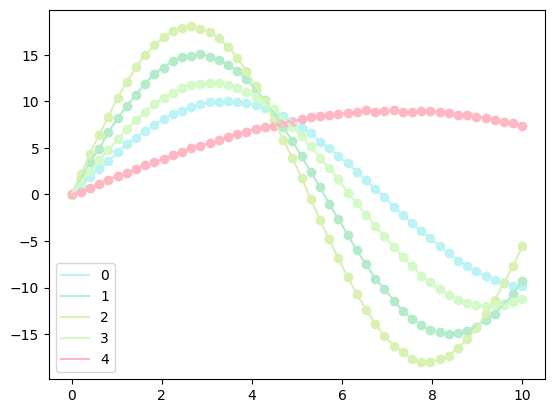

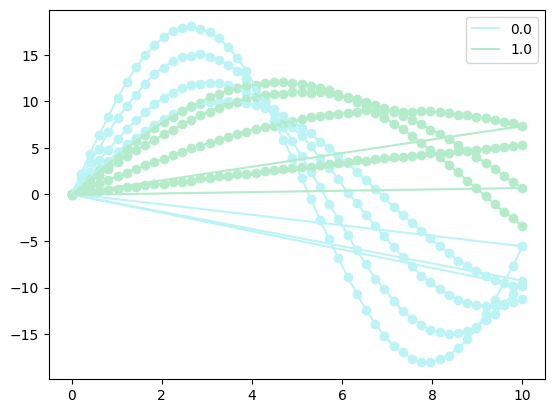

In [265]:
color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7','#FFB7C3']
index = 0
for pend in np.unique(df['pendulum_id']):
    subset = df[df['pendulum_id']==pend]
    plt.plot(subset['time'], subset['pos'],
                color = color_list[index],
                label = pend)
    plt.scatter(subset['time'], subset['pos'],
                color = color_list[index])
    if pend > 3:
        break
    index+=1
plt.legend()
plt.show()

index = 0
for planet in np.unique(df['planet_id']):
    subset = df[df['planet_id']==planet]
    plt.plot(subset['time'], subset['pos'],
                color = color_list[index],
                label = planet)
    plt.scatter(subset['time'], subset['pos'],
                color = color_list[index])
    if planet > 3:
        break
    index+=1
plt.legend()
plt.show()

<div class="alert alert-info">
Before running anything, investigate what the prior predictive distribution looks like.
</div>

(400,) (400,) (400,)


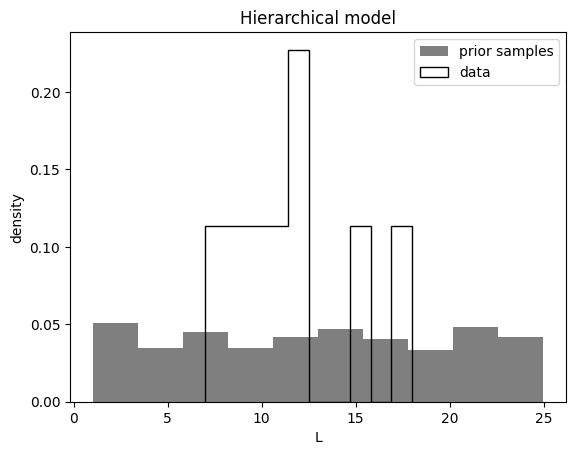

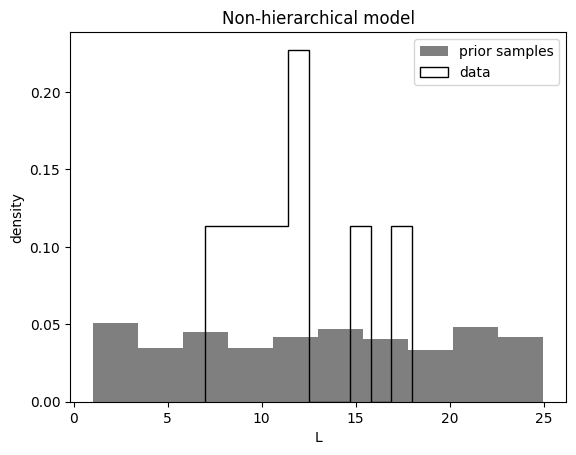

In [266]:
# Generate samples from the prior...

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time = df["time"].values
pend_code = df["pendulum_id"].values

print(np.shape(planet_code), np.shape(pend_code), np.shape(time))
prior_pred = numpyro.infer.Predictive(model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time
)

# ...and plot them:
label = "prior samples"
plt.hist(
    prior_pred["L"].flatten(),
    10,
    #range=(0.2, 3.0),
    #histtype="step",
    color="k",
    lw=0.5,
    alpha=0.5,
    label=label,
    density=True
)
    

plt.hist(df["length"], 10, histtype="step", color="black", label="data", density=True)
plt.legend()
plt.xlabel("L")
plt.ylabel("density")
plt.title("Hierarchical model")
plt.show()

prior_pred = numpyro.infer.Predictive(nonh_model, num_samples=50)(
    random.PRNGKey(11), pend_code, time
)

# ...and plot them:
label = "prior samples"
plt.hist(
    prior_pred["L"].flatten(),
    10,
    #range=(0.2, 3.0),
    #histtype="step",
    color="k",
    lw=0.5,
    alpha=0.5,
    label=label,
    density=True
)
    

plt.hist(df["length"], 10, histtype="step", color="black", label="data", density=True)
plt.legend()
plt.xlabel("L")
plt.ylabel("density")
plt.title("Non-hierarchical model")
plt.show()

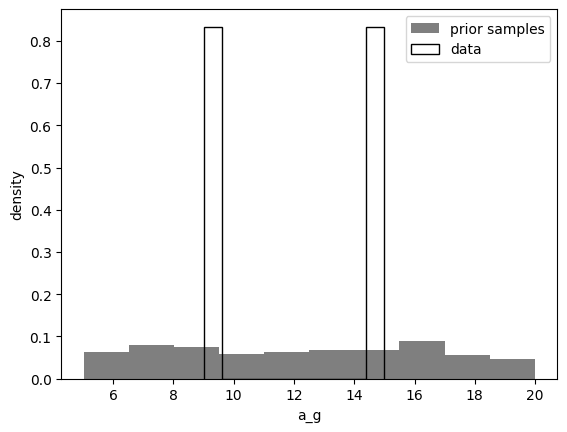

In [267]:
# the same for a_g
label = "prior samples"
plt.hist(
    prior_pred["a_g"].flatten(),
    10,
    #range=(0.2, 3.0),
    #histtype="step",
    color="k",
    lw=0.5,
    alpha=0.5,
    label=label,
    density=True
)
    

plt.hist(df["a_g"], 10, histtype="step", color="black", label="data", density=True)
plt.legend()
plt.xlabel("a_g")
plt.ylabel("density");

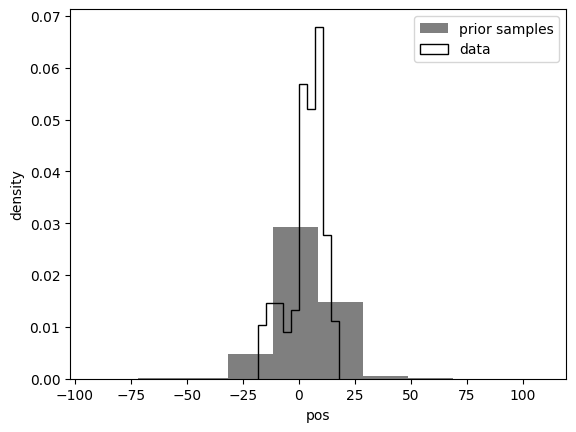

In [268]:
# also sample from the position
label = "prior samples"
plt.hist(
    prior_pred["obs"].flatten(),
    10,
    #range=(0.2, 3.0),
    #histtype="step",
    color="k",
    lw=0.5,
    alpha=0.5,
    label=label,
    density=True
)
    

plt.hist(df["pos"], 10, histtype="step", color="black", label="data", density=True)
plt.legend()
plt.xlabel("pos")
plt.ylabel("density");

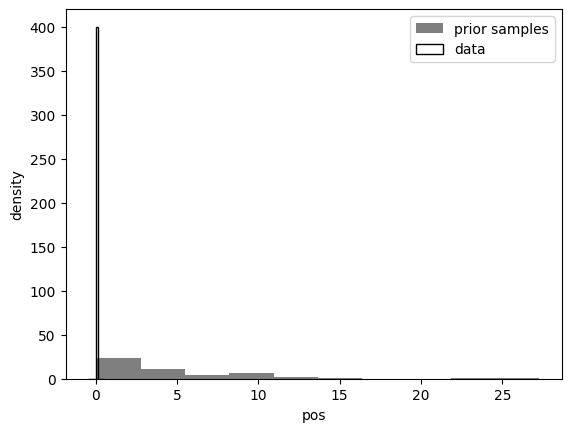

In [272]:
# also sample from the position
label = "prior samples"
plt.hist(
    prior_pred["σ"].flatten(),
    10,
    #range=(0.2, 3.0),
    #histtype="step",
    color="k",
    lw=0.5,
    alpha=0.5,
    label=label,
#    density=True
)
    

plt.hist(df["pos_err"], 10, histtype="step", color="black", label="data")#, density=True)
plt.legend()
plt.xlabel("pos")
plt.ylabel("density");

## Run the inference for the hierarchical case

In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc.run(rng_key, planet_code, pend_code, time, pos_obs=pend_obs)

posterior_samples = mcmc.get_samples()

sample:  68%|█████████████████        | 2738/4000 [01:29<00:45, 27.78it/s, 1023 steps of size 6.85e-04. acc. prob=0.87]

In [227]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],10.004,0.009,9.987,10.022,0.001,0.000,309.0,598.0,NaN
L[1],14.992,0.009,14.976,15.010,0.001,0.000,271.0,482.0,NaN
L[2],17.996,0.009,17.981,18.013,0.000,0.000,322.0,675.0,NaN
L[3],12.004,0.010,11.984,12.023,0.001,0.000,323.0,498.0,NaN
L[4],9.009,0.009,8.993,9.025,0.000,0.000,308.0,431.0,NaN
L[5],6.711,0.179,6.405,7.050,0.018,0.013,96.0,153.0,NaN
L[6],11.000,0.010,10.983,11.021,0.001,0.000,359.0,536.0,NaN
L[7],12.006,0.010,11.987,12.027,0.001,0.000,257.0,572.0,NaN
a_g[0],12.626,2.805,7.233,16.255,0.607,0.435,23.0,47.0,NaN
a_g[1],11.784,3.225,5.673,15.820,1.163,0.856,10.0,25.0,NaN


In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [229]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc.get_samples()['a_g']))

shape of L samples (2000, 8)
shape of a_g samples (2000, 2)


In [230]:
posterior = mcmc.get_samples()
posterior

{'L': Array([[ 9.998234 , 14.996814 , 17.991655 , ...,  6.8714275, 11.014835 ,
         11.988633 ],
        [10.004198 , 14.983795 , 17.987001 , ...,  6.914153 , 11.016724 ,
         11.989126 ],
        [ 9.997532 , 14.971997 , 17.99176  , ...,  6.9277835, 11.010226 ,
         12.009877 ],
        ...,
        [10.010525 , 14.988259 , 17.980532 , ...,  6.3546953, 11.001629 ,
         12.007526 ],
        [10.002339 , 14.991592 , 17.969053 , ...,  6.545839 , 11.008264 ,
         12.012211 ],
        [10.006518 , 14.993924 , 17.976967 , ...,  6.936032 , 10.996269 ,
         12.014328 ]], dtype=float32),
 'a_g': Array([[14.3117695, 15.73367  ],
        [14.197128 , 15.844404 ],
        [14.432383 , 15.7916   ],
        ...,
        [11.899557 , 13.091489 ],
        [12.87925  , 12.642942 ],
        [12.065429 , 11.483793 ]], dtype=float32),
 'theta': Array([[1.2522026 , 1.0028651 , 0.9507768 , ..., 1.4874626 , 0.83946306,
         0.83338994],
        [1.2359987 , 0.9976411 , 0.9469105 

In [231]:
# So because the sampler chain doesn't save the position at each point in time
# i have created a thing that samples position for us
def pos_calculator(L, theta, a_g, sigma, time):
    
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L)) * time) + sigma * np.random.randn(len(time))
    return pos

true L = 10.0
posterior L = 10.0 +/- 0.009999999776482582
true theta = 0.7853981633974482
posterior theta = 1.1299999952316284 +/- 0.25999999046325684
true a_g = 9.0
posterior a_g = 13.270000457763672 +/- 2.799999952316284


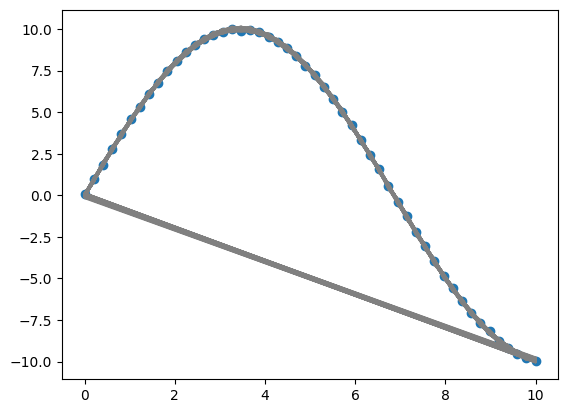

In [232]:
# visualize what draws from this sampler give you compared to the true distribution
# df[df['pend_code'] == 0]
number = 0
sub_df = df[df['pend_code'] == number]
print(f"true L = {np.mean(sub_df['length'].values)}")
print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
print(f"true theta = {np.mean(sub_df['theta'].values)}")
print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
# let's actually draw from this posterior:
plt.clf()

#print(pos_calculator(posterior, time))
for j in range(2000):
    L = posterior['L'][j,number]
    theta = posterior['theta'][j,number]
    a_g = posterior['a_g'][j,number]#FIXXXXX
    sigma = posterior['σ'][j]
    plt.plot(time, pos_calculator(L,theta,a_g,sigma,time), color = 'grey')
    if j > 100:
        break
plt.scatter(sub_df['time'].values, sub_df['pos'].values)

plt.show()


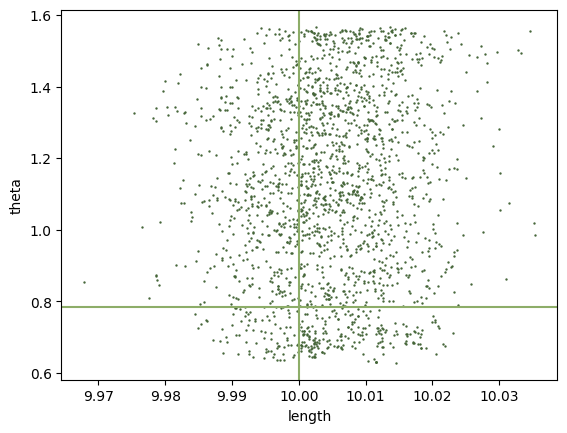

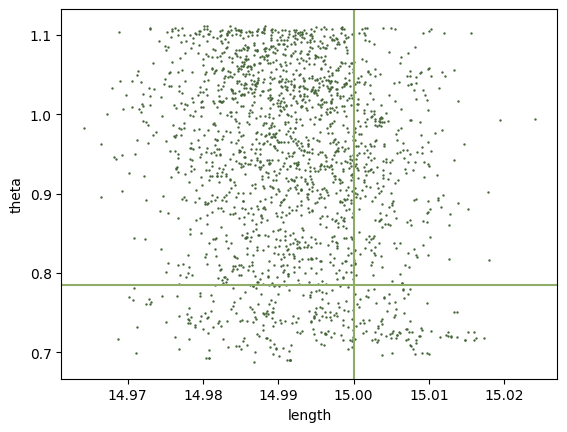

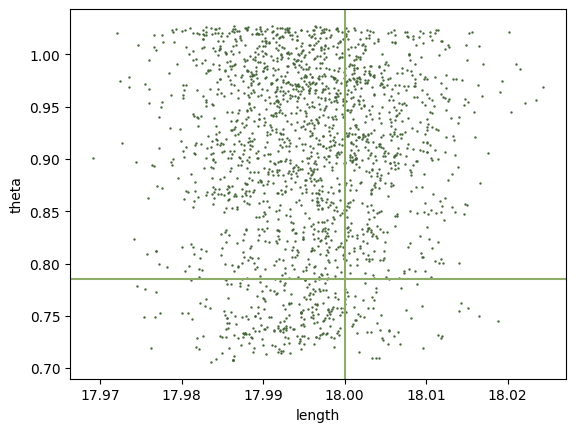

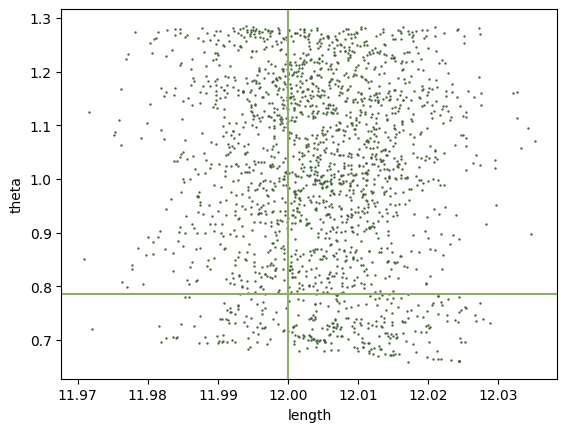

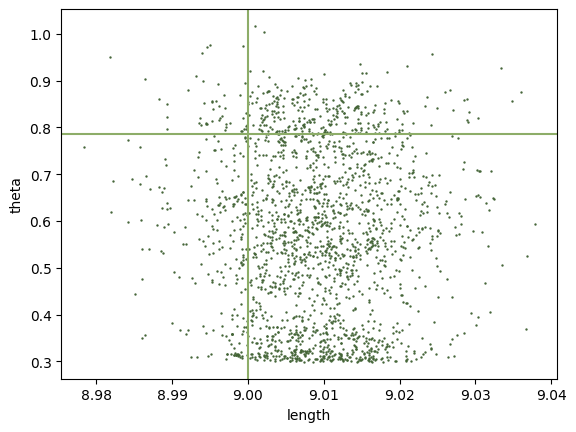

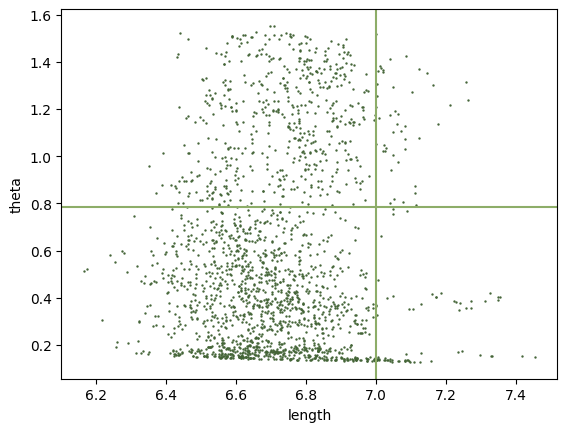

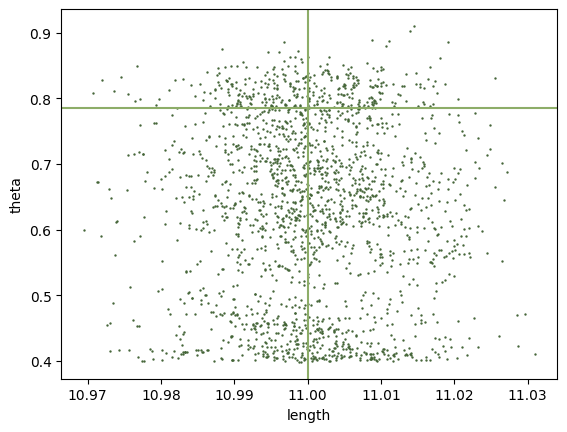

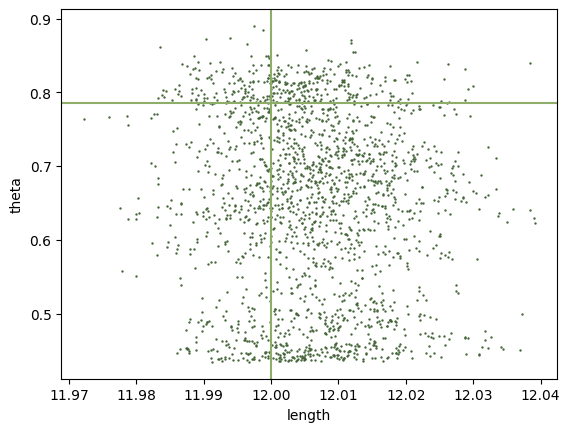

In [233]:
# It would be great if there is some way to create your own corner plot with the parameters
plt.clf()
for number in np.unique(df['pend_code']):

    plt.scatter(posterior['L'][:,number],posterior['theta'][:,number],
                color = '#436436', s = 0.5)
    plt.axvline(x = np.mean(df[df['pend_code'] == number]['length']), color = '#8DAD68')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['theta']), color = '#8DAD68')
    plt.xlabel('length')
    plt.ylabel('theta')
    plt.show()


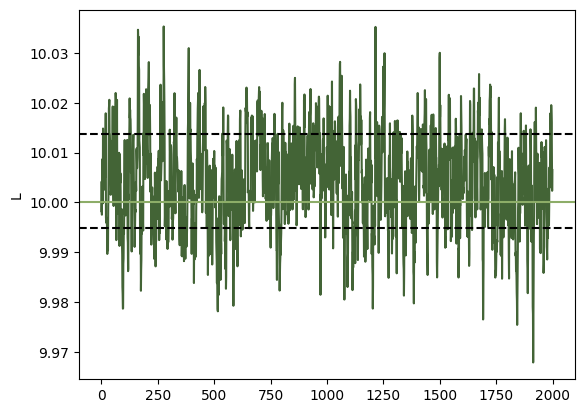

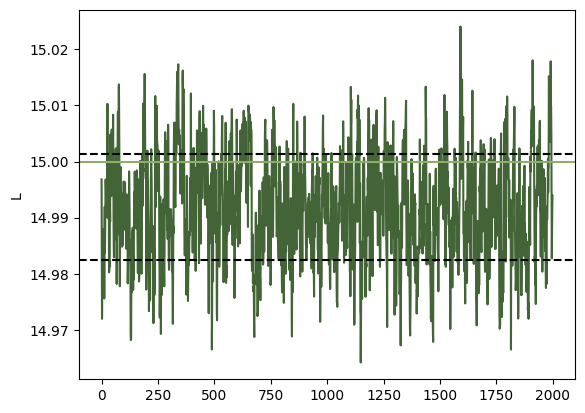

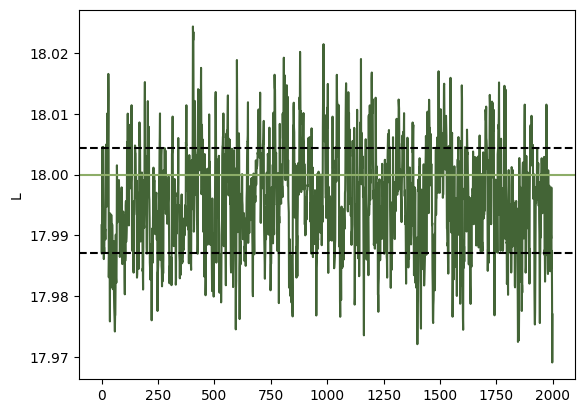

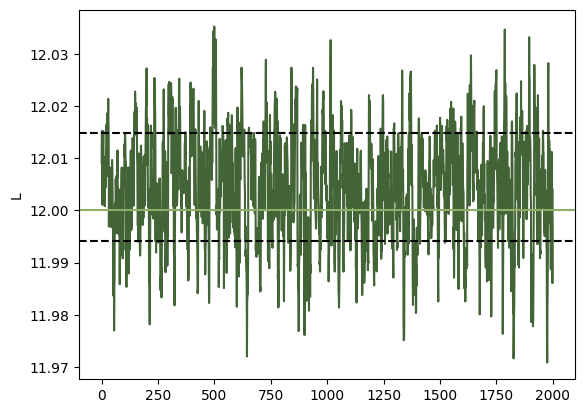

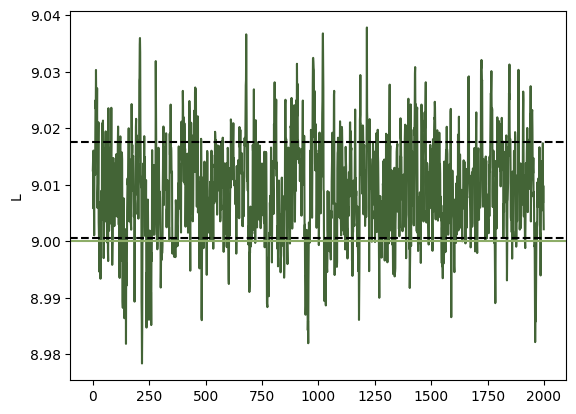

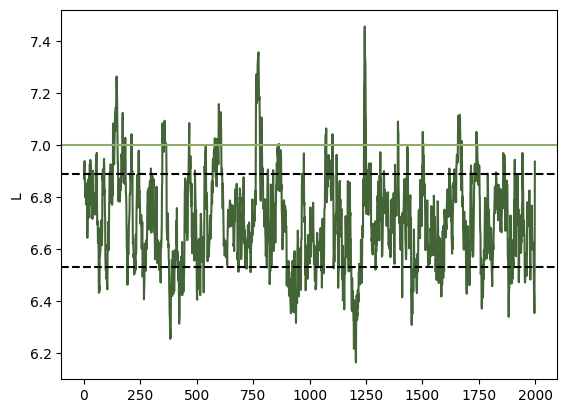

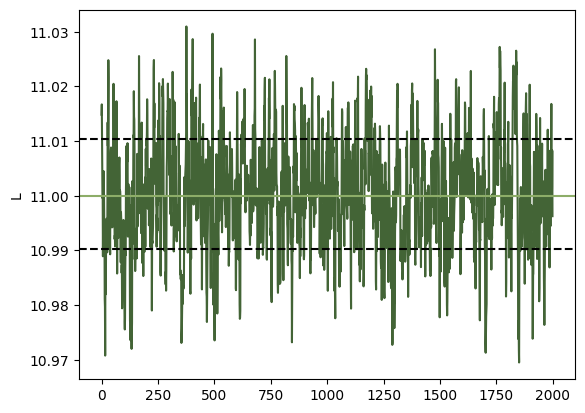

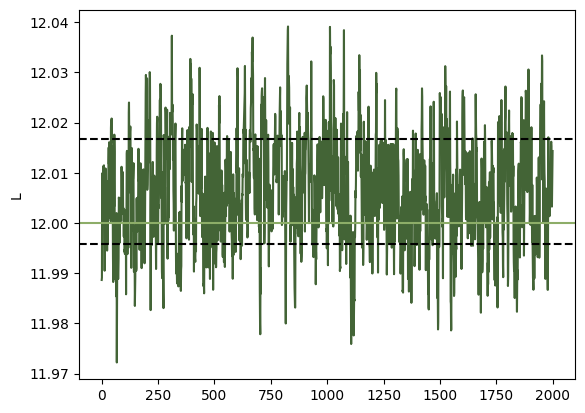

,length,theta,a_g,pos_err,planet_id,time,pendulum_id,pos,pend_code,planet_code
0,10.0,0.785398,9.0,0.05,0.0,0.000000,0,0.050699,0,0
1,10.0,0.785398,9.0,0.05,0.0,0.204082,0,0.968807,0,0
2,10.0,0.785398,9.0,0.05,0.0,0.408163,0,1.840261,0,0
3,10.0,0.785398,9.0,0.05,0.0,0.612245,0,2.788152,0,0
4,10.0,0.785398,9.0,0.05,0.0,0.816327,0,3.709958,0,0
...,...,...,...,...,...,...,...,...,...,...
395,12.0,0.785398,15.0,0.05,1.0,9.183673,7,-0.137375,7,1
396,12.0,0.785398,15.0,0.05,1.0,9.387755,7,-1.101567,7,1
397,12.0,0.785398,15.0,0.05,1.0,9.591837,7,-1.826919,7,1
398,12.0,0.785398,15.0,0.05,1.0,9.795918,7,-2.651019,7,1


In [234]:
# figure out what's going on with the parameters that are individual for each pendulum
plt.clf()
for number in np.unique(df['pend_code']):
    plt.plot(mcmc.get_samples()['L'][:,number], color = '#436436')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['length']), color = '#8DAD68')
    plt.axhline(y = np.mean(mcmc.get_samples()['L'][:,number]) - np.std(mcmc.get_samples()['L'][:,number]), 
                color = 'black', ls = '--')
    plt.axhline(y = np.mean(mcmc.get_samples()['L'][:,number]) + np.std(mcmc.get_samples()['L'][:,number]), 
            color = 'black', ls = '--')

    plt.ylabel('L')
    plt.show()
df

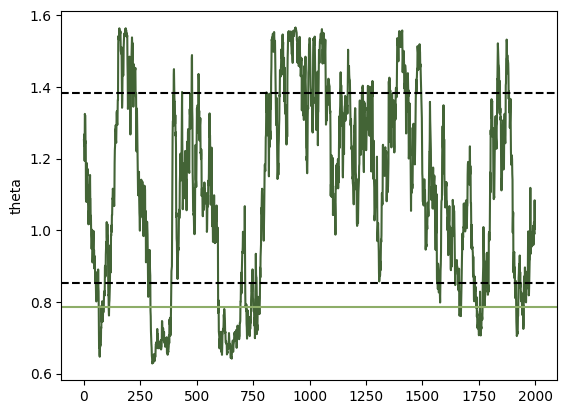

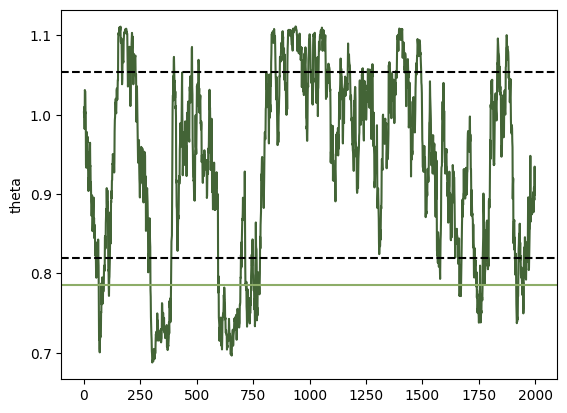

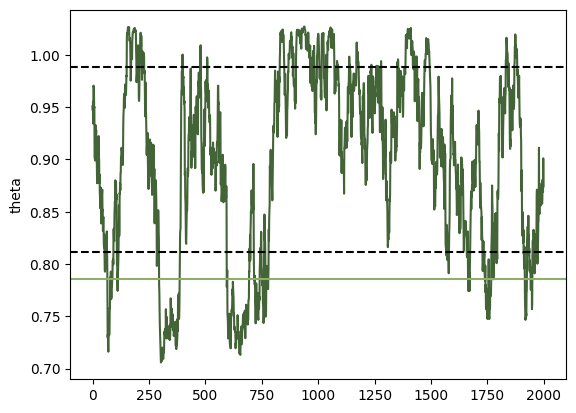

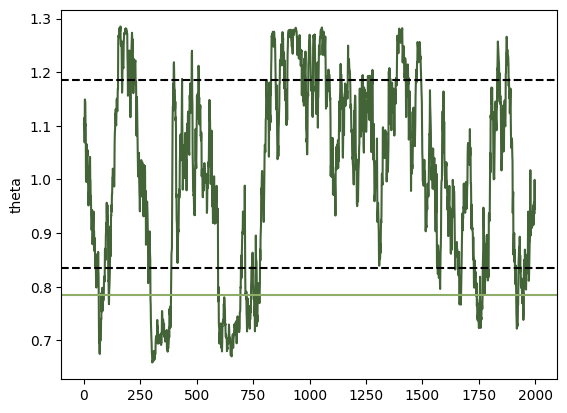

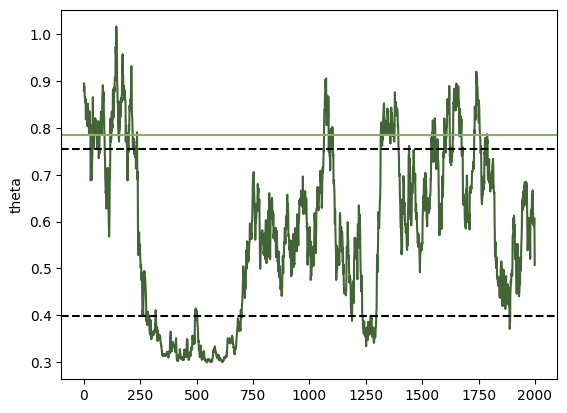

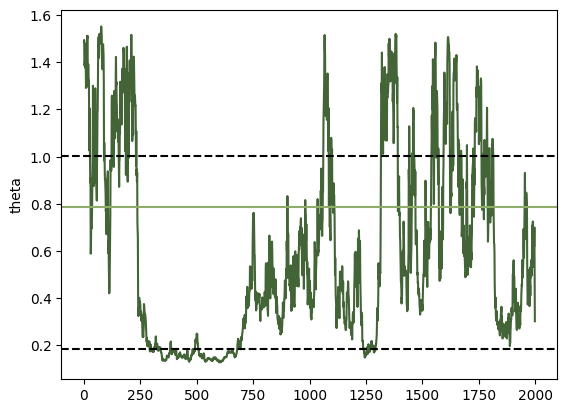

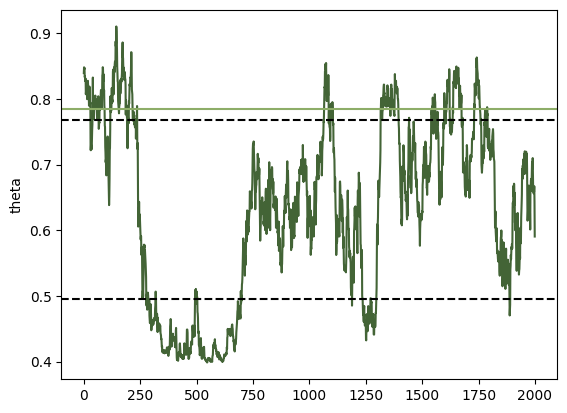

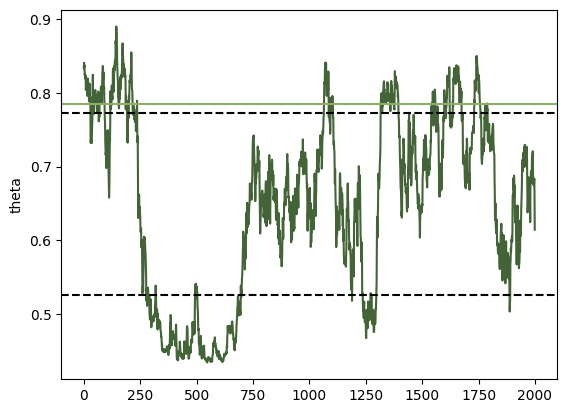

In [235]:
# figure out what's going on with the parameters that are individual for each pendulum
plt.clf()
for number in np.unique(df['pend_code']):
    plt.plot(mcmc.get_samples()['theta'][:,number], color = '#436436')
    plt.axhline(y = np.mean(df[df['pend_code'] == number]['theta']), color = '#8DAD68')
    plt.axhline(y = np.mean(mcmc.get_samples()['theta'][:,number]) - np.std(mcmc.get_samples()['theta'][:,number]), 
                color = 'black', ls = '--')
    plt.axhline(y = np.mean(mcmc.get_samples()['theta'][:,number]) + np.std(mcmc.get_samples()['theta'][:,number]), 
            color = 'black', ls = '--')

    plt.ylabel('theta')
    plt.show()

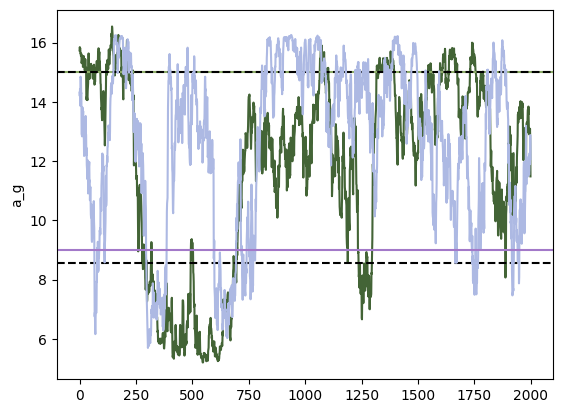

,length,theta,a_g,pos_err,planet_id,time,pendulum_id,pos,pend_code,planet_code
0,10.0,0.785398,9.0,0.05,0.0,0.000000,0,0.050699,0,0
1,10.0,0.785398,9.0,0.05,0.0,0.204082,0,0.968807,0,0
2,10.0,0.785398,9.0,0.05,0.0,0.408163,0,1.840261,0,0
3,10.0,0.785398,9.0,0.05,0.0,0.612245,0,2.788152,0,0
4,10.0,0.785398,9.0,0.05,0.0,0.816327,0,3.709958,0,0
...,...,...,...,...,...,...,...,...,...,...
395,12.0,0.785398,15.0,0.05,1.0,9.183673,7,-0.137375,7,1
396,12.0,0.785398,15.0,0.05,1.0,9.387755,7,-1.101567,7,1
397,12.0,0.785398,15.0,0.05,1.0,9.591837,7,-1.826919,7,1
398,12.0,0.785398,15.0,0.05,1.0,9.795918,7,-2.651019,7,1


In [236]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1], color = '#436436')
plt.axhline(y = np.mean(df[df['planet_code'] == 1]['a_g']), color = '#8DAD68')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) - np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) + np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')

plt.ylabel('a_g')

plt.plot(mcmc.get_samples()['a_g'][:,0], color = '#ADB9E3')
plt.axhline(y = np.mean(df[df['planet_code'] == 0]['a_g']), color = '#A379C9')
plt.ylabel('a_g')
plt.show()
df

In [237]:
# This is the overall sampler
corner.corner(inf_data);

In [ ]:
print(np.shape(mcmc.get_samples()['a_g'][:,1]))

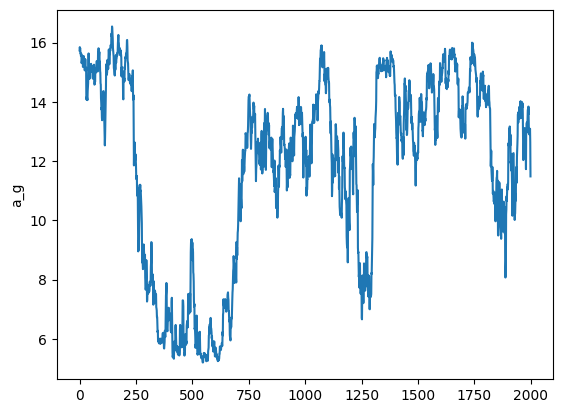

In [239]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1])
plt.ylabel('a_g')
plt.show()

## Now run the inference for the non-hierarchical case

In [258]:
nuts_kernel_nonh = NUTS(nonh_model)

mcmc_nonh = MCMC(nuts_kernel_nonh, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc_nonh.run(rng_key, pend_code, time, pos_obs=pend_obs)


sample: 100%|█████████████████████████| 4000/4000 [00:22<00:00, 173.93it/s, 255 steps of size 2.54e-02. acc. prob=0.95]


In [259]:
inf_data_nonh = az.from_numpyro(mcmc_nonh)
az.summary(inf_data_nonh)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],10.053,0.884,8.472,11.730,0.018,0.013,2390.0,1548.0,NaN
L[1],14.929,0.862,13.247,16.475,0.017,0.012,2597.0,1433.0,NaN
L[2],6.614,0.549,5.632,7.463,0.016,0.011,1302.0,1227.0,NaN
L[3],12.072,0.819,10.554,13.568,0.017,0.012,2253.0,1414.0,NaN
L[4],9.356,1.048,7.395,11.110,0.029,0.022,2026.0,767.0,NaN
L[5],9.461,4.934,3.104,20.188,0.165,0.123,1123.0,866.0,NaN
L[6],10.906,0.875,9.221,12.484,0.017,0.012,2566.0,1469.0,NaN
L[7],11.891,0.947,10.011,13.562,0.022,0.016,1831.0,1264.0,NaN
a_g[0],11.572,3.343,5.165,16.487,0.087,0.062,1459.0,1309.0,NaN
a_g[1],13.397,4.236,6.423,19.973,0.114,0.085,1292.0,1288.0,NaN


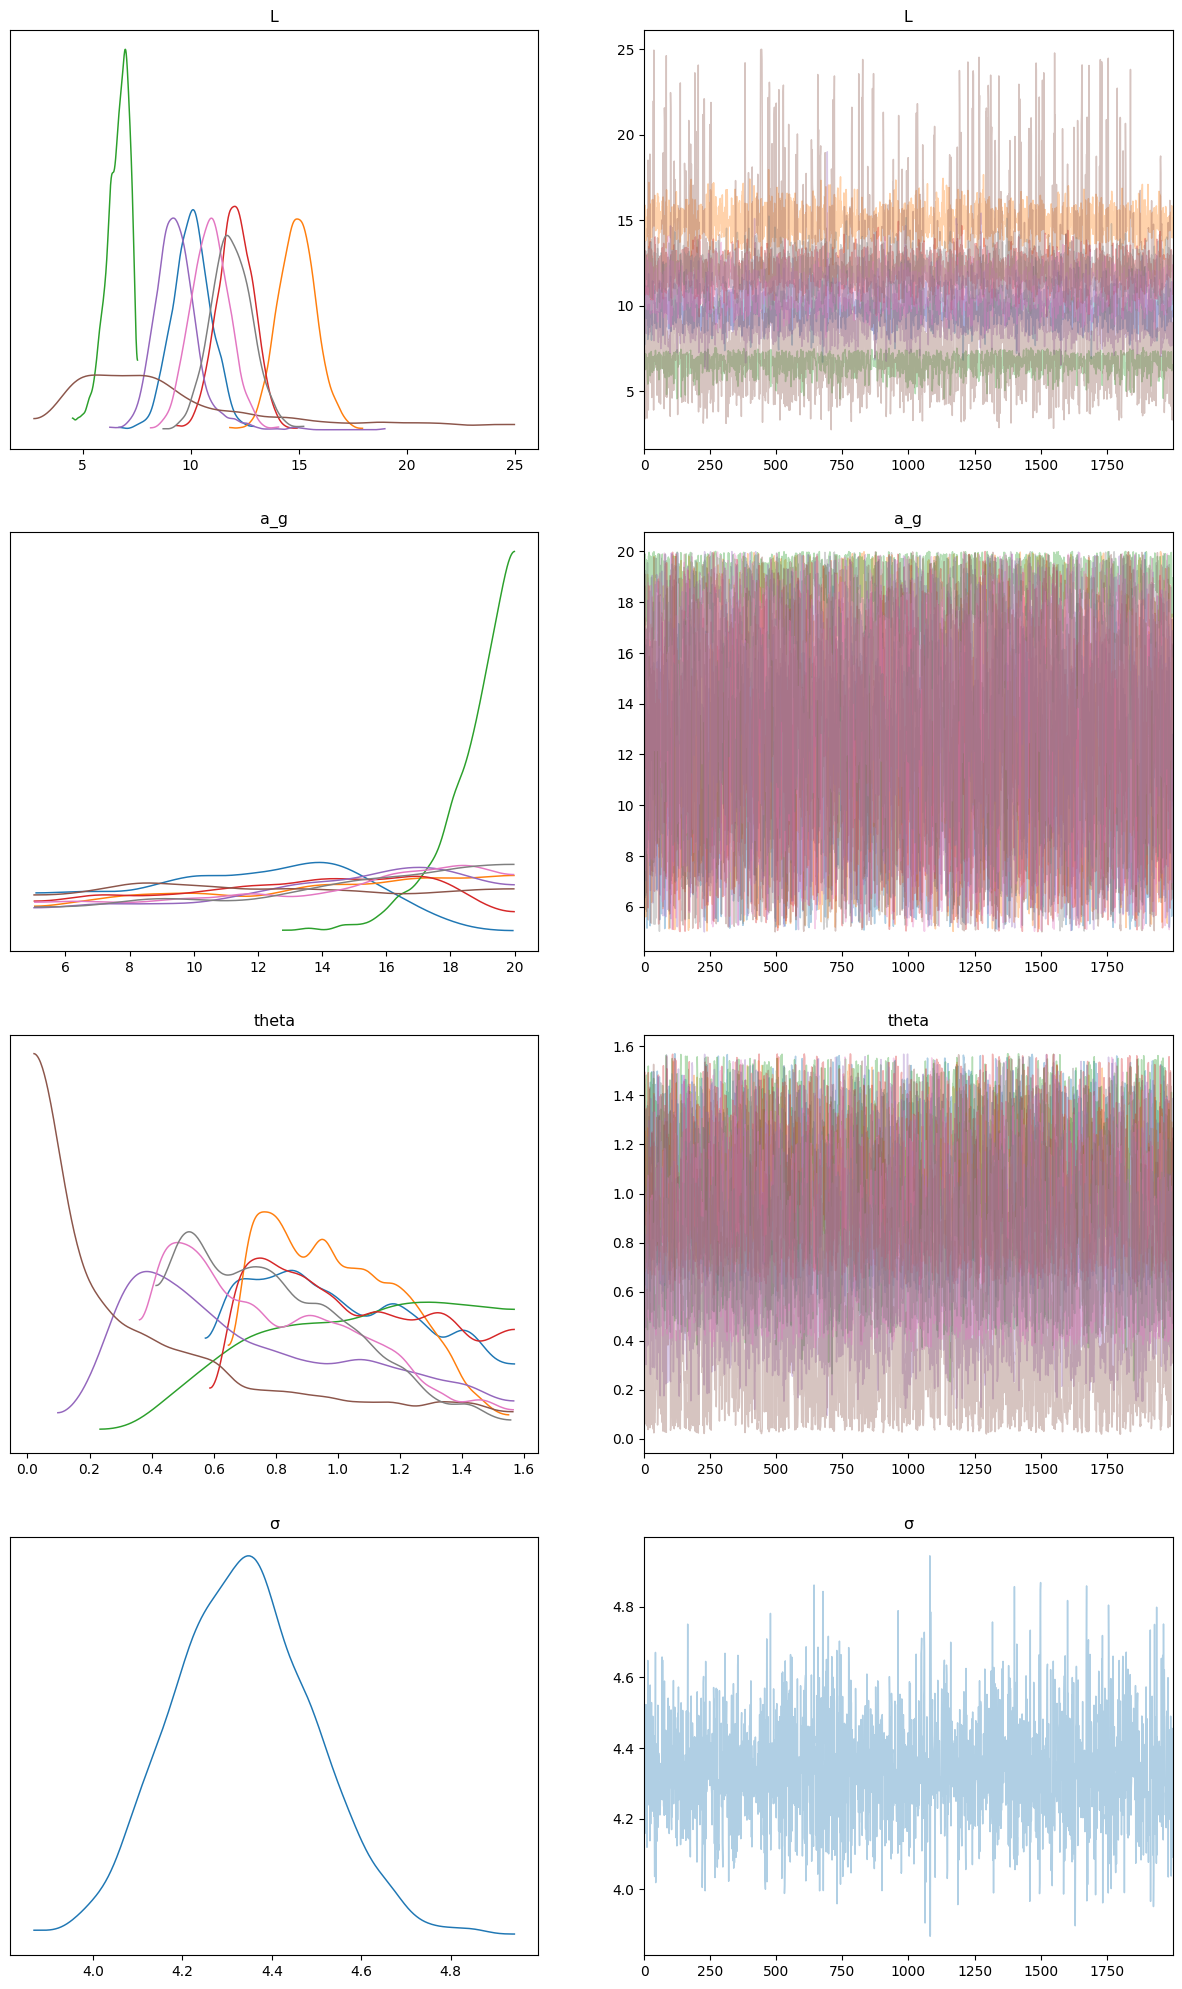

In [260]:
data_nonh = az.from_numpyro(mcmc_nonh)
az.plot_trace(data_nonh, compact=True, figsize=(15, 25));

In [261]:
posterior_nonh = mcmc_nonh.get_samples()
posterior_nonh

{'L': Array([[11.471117 , 15.457235 ,  5.67127  , ...,  7.7719746,  9.263554 ,
         11.191937 ],
        [ 9.000922 , 14.534237 ,  7.4085712, ...,  5.627599 , 12.266147 ,
         12.286668 ],
        [ 7.7089825, 15.324807 ,  6.393275 , ...,  4.9065337, 10.850351 ,
         12.72182  ],
        ...,
        [10.177157 , 14.09075  ,  6.3717666, ...,  9.013232 , 10.355555 ,
         12.961657 ],
        [ 9.841737 , 13.961256 ,  6.509966 , ...,  3.3017588, 10.737913 ,
         11.117223 ],
        [ 9.344152 , 15.134327 ,  6.52116  , ...,  5.6160636, 12.384895 ,
         10.089783 ]], dtype=float32),
 'a_g': Array([[ 6.234973 ,  7.466771 , 15.766489 , ..., 15.675756 ,  9.354723 ,
         19.933071 ],
        [14.293506 , 16.828468 , 19.84603  , ...,  9.208827 , 17.895046 ,
          7.167426 ],
        [10.608462 , 16.843365 , 18.756554 , ..., 10.797556 , 17.417965 ,
         17.489893 ],
        ...,
        [ 6.925129 , 17.532139 , 17.895416 , ..., 17.329922 ,  6.9521656,
       